In [ ]:
from PubMedDownloader import PubMedEntrezDownloader
from datetime import datetime
import os
from dotenv import load_dotenv
load_dotenv()

async def main():
    downloader = PubMedEntrezDownloader("olandechris@gmail.com")
    pmids = await downloader.search_pubmed("", max_results=10000)
    articles = await downloader.fetch_article_details(pmids)
    downloader.save_to_json(articles, "results.json")

await main()

In [ ]:
from document_processor import DocumentProcessor
docs = DocumentProcessor()
docs.get_stats(documents)

In [ ]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
import logging
from batchprocessor import PMCBatchProcessor
from document_processor import DocumentProcessor

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("MainScript")

async def main():
    doc_processor = DocumentProcessor(embeddings_model="BAAI/bge-small-en-v1.5")

    batch_processor = PMCBatchProcessor(
        document_processor=doc_processor,
        batch_size=96,
        max_concurrent_batches=3,
        retry_attempts=2,
        retry_delay=1.0,
        inter_batch_delay=0.1
    )

    file_path = "../data/research20250605_002659.json" 
    output_directory = "../data/output/processed_pmc_data"

    logger.info(f"Starting batch processing of {file_path}")

    try:
        processing_results = await batch_processor.process_pmc_file_async(
            file_path=file_path
        )

        batch_processor.save_results(processing_results, output_directory, save_batch_details=True)

        s = processing_results['processing_summary']
        logger.info(f"Processing complete: {s['total_documents']:,} docs → {s['total_chunks']:,} chunks ({s['processing_time']:.1f}s)")
        logger.info(f"Success rate: {s['success_rate']:.1f}%")

    except Exception as e:
        logger.error(f"An error occurred during batch processing: {e}", exc_info=True)


if __name__ == "__main__":
    await main()

In [1]:
import json
from pathlib import Path
from langchain.schema import Document

data_path = Path("../data/output/processed_pmc_data/pmc_chunks.json")
with data_path.open(encoding="utf-8") as f:
    data = json.load(f)

# Create documents
documents = [
    Document(page_content=doc["content"], metadata=doc["metadata"])
    for doc in data["documents"]
]

In [2]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [3]:
from src.core.main import Main

main = Main()

/home/olande/Desktop/FinalRAG/src/core/main.py:55: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  return HuggingFaceEmbeddings(
2025-06-27 15:06:22,500 - INFO - PyTorch version 2.7.0 available.
2025-06-27 15:06:22,506 - INFO - Polars version 1.30.0 available.
2025-06-27 15:06:23,077 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-06-27 15:06:29,871 - INFO - CacheManager initialized. Cache directory: ../my_cache
2025-06-27 15:06:31,388 - INFO - Cache loaded from ../my_cache/cache.pkl.
/home/olande/Langchain/.venv/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:290: FutureWarning: 
The defau

Loaded existing graph with 17330 nodes and 1815 edges


2025-06-27 15:06:35,799 - INFO - Use pytorch device_name: cpu
2025-06-27 15:06:35,801 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-06-27 15:06:39,883 - INFO - Semantic cache initialized and set globally.
2025-06-27 15:06:39,934 - INFO - Attempting to load index from ../faiss_index...
2025-06-27 15:06:39,942 - INFO - Loading faiss.
2025-06-27 15:06:40,020 - INFO - Successfully loaded faiss.
2025-06-27 15:06:40,034 - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-06-27 15:06:40,517 - INFO - Successfully loaded FAISS index with 17330 documents.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jinaai/jina-reranker-v1-turbo-en and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0

2025-06-27 15:10:58,949 - INFO - Processing 17330 documents
2025-06-27 15:10:58,975 - INFO - QueryEngine initialized.
2025-06-27 15:10:58,976 - INFO - Document processing completed successfully
2025-06-27 15:10:58,979 - INFO - Processing query: 'How are brain tumors detected?'
2025-06-27 15:10:58,981 - INFO - Starting query for: 'How are brain tumors detected?'


Knowledge graph already exists with 17330 nodes and 1815 edges


2025-06-27 15:11:01,000 - INFO - Best match score 0.5534 above threshold (0.5).
2025-06-27 15:11:28,936 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-27 15:11:29,752 - INFO - Updated FAISS index and saved to ../semantic_cache_index
2025-06-27 15:11:30,133 - INFO - Semantic match found with score 0.1240.
2025-06-27 15:11:30,137 - INFO - Chunk analysis - Count: 2, Avg length: 12.0 words, Range: 12-12 words


Document 1:
Metadata: {'id': 0, 'relevance_score': np.float32(0.15314397), 'pmid': '40438692', 'title': 'A single-institution experience with intraoperative in vivo confocal laser endomicroscopy for brain tumors in 50 patients.', 'authors': 'Xu Y; On TJ; Abramov I; Alcantar-Garibay O; Hartke JN; Eschbacher JM; Yangi K; Lawton MT; Smith KA; Porter RW; Preul MC', 'journal': 'Frontiers in oncology', 'volume': '15', 'issue': '', 'year': '2025', 'month': '', 'day': '', 'pub_date': '2025', 'doi': '10.3389/fonc.2025.1565935', 'pmc_id': '', 'mesh_terms': '', 'publication_types': 'Journal Article', 'pubmed_url': 'https://pubmed.ncbi.nlm.nih.gov/40438692/', 'doi_url': 'https://doi.org/10.3389/fonc.2025.1565935'}

clinically approved CLE system for intraoperative <i>in vivo</i> imaging of
brain tumors.
--------------------------------------------------------------------------------
Document 2:
Metadata: {'id': 1, 'relevance_score': np.float32(0.10839871), 'pmid': '40438692', 'title': 'A single-in

2025-06-27 15:11:30,901 - INFO - Semantic match found with score 0.4045.
2025-06-27 15:11:30,905 - WARNING - LLM returned unstructured response, falling back to text parsing
2025-06-27 15:11:31,241 - INFO - Semantic match found with score 0.4045.



Step 4 - Node 1371:
Content: clinically approved CLE system for intraoperative <i>in vivo</i> imaging of brain tumors. A total of...
Concepts: Confocal laser endomicroscopy, brain tumors, CLE
--------------------------------------------------


2025-06-27 15:11:31,654 - INFO - Semantic match found with score 0.3955.
2025-06-27 15:11:31,658 - WARNING - LLM returned unstructured response, falling back to text parsing
2025-06-27 15:11:32,047 - INFO - Semantic match found with score 0.3955.
2025-06-27 15:11:32,050 - INFO - Priority queue exhausted without finding a complete answer.
2025-06-27 15:11:32,053 - INFO - Generating final answer from accumulated context.
2025-06-27 15:11:32,486 - INFO - Best match score 0.5617 above threshold (0.5).
2025-06-27 15:11:34,832 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-27 15:11:36,680 - INFO - Updated FAISS index and saved to ../semantic_cache_index
2025-06-27 15:11:36,681 - INFO - Final Answer: Brain tumors are detected using a clinically approved Confocal Laser Endomicroscopy (CLE) system, which allows for intraoperative in vivo visualization of tissue histoarchitecture and identification o...
2025-06-27 15:11:36,682 - INFO - Startin

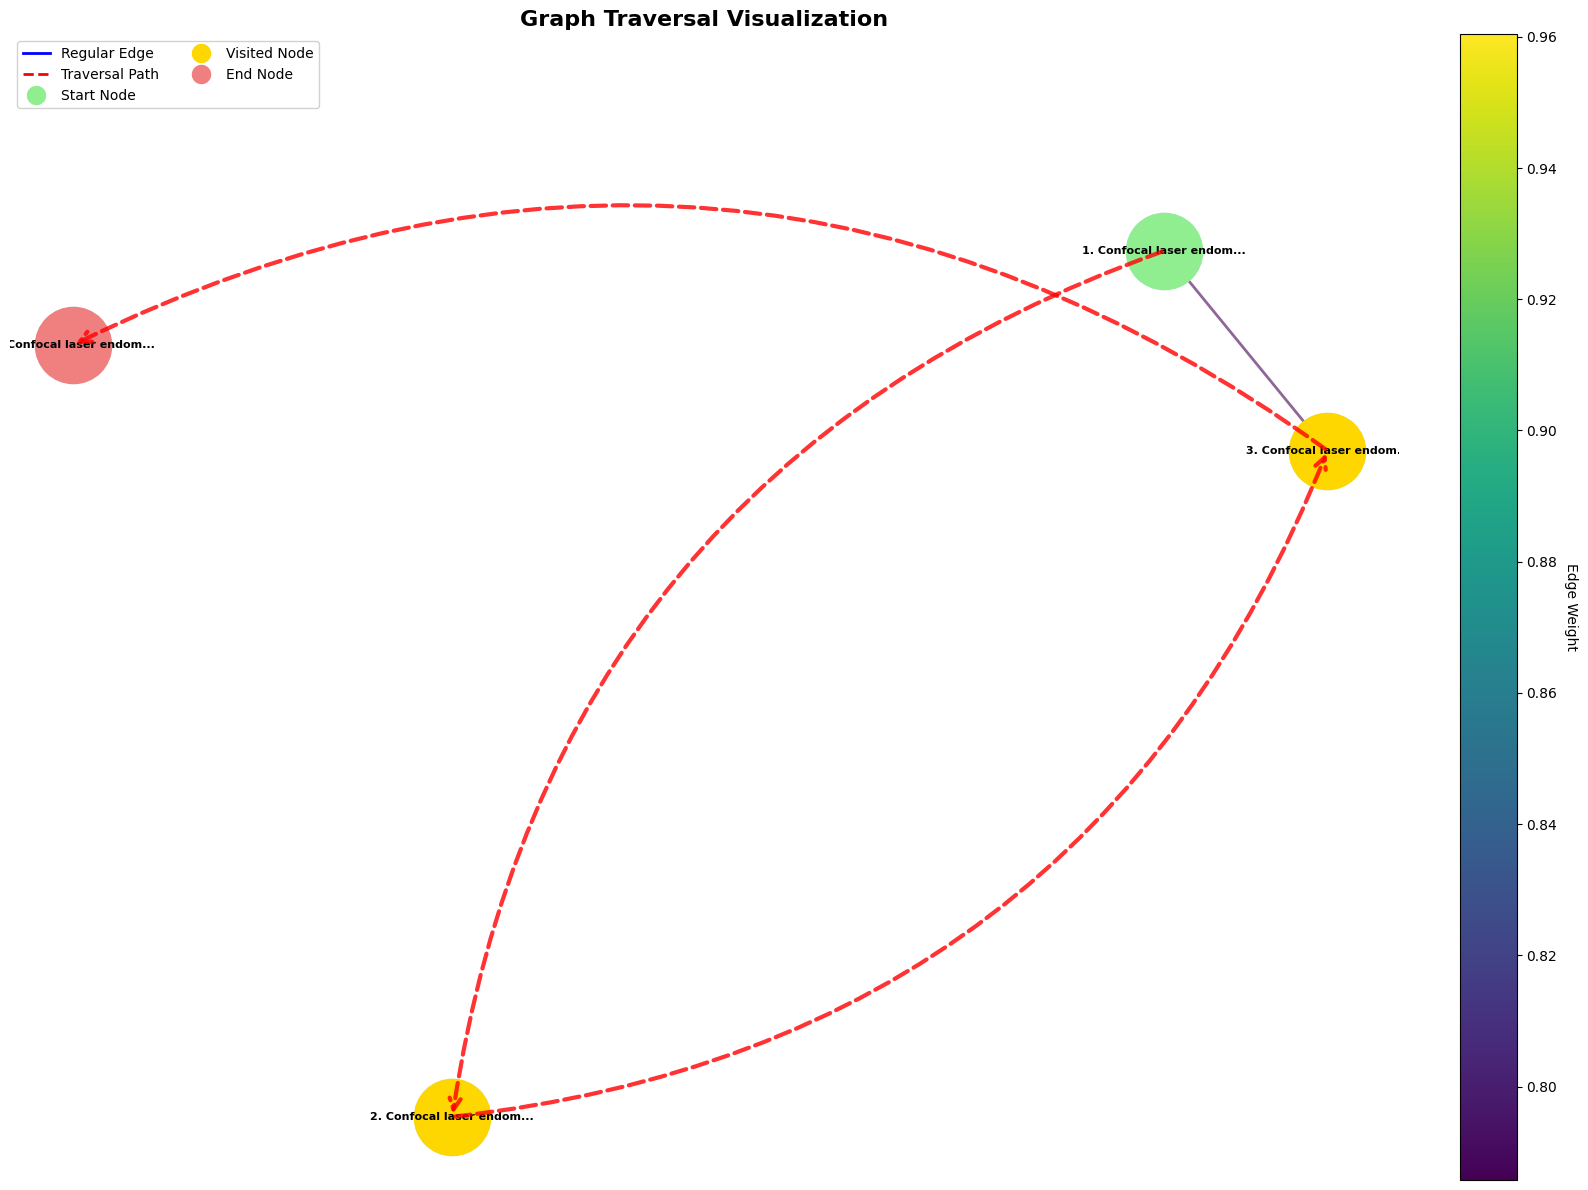

2025-06-27 15:11:37,422 - INFO - Visualization completed successfully


In [8]:

await main.process_documents(documents)
response, path, content = await main.query("How are brain tumors detected?")